In [1]:
# Imports and initialization

import torch
import torch.nn as nn
import numpy as np
from scipy.stats import qmc
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import os
from tqdm import trange
import csv

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_dtype(torch.float64)

plt.rcParams['figure.figsize'] = [6.4, 4.8]
plt.rcParams['figure.dpi'] = 100

seed = 114514
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


In [2]:
# Problem constants

r_0 = 0.5
beta = np.array([1.0, 3.0])
alpha = 1.0
T = 0.5 * np.pi


In [3]:
# Shallow neural networks for PINN

class PINN(nn.Module):
    
    def __init__(self, in_dim, h_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=h_dim),
            nn.Tanh(),
            nn.Linear(in_features=h_dim, out_features=h_dim),
            nn.Tanh(),
            nn.Linear(in_features=h_dim, out_features=h_dim),
            nn.Tanh(),
            nn.Linear(in_features=h_dim, out_features=out_dim, bias=False)
        )
        
    def forward(self, x):
        out = self.model(x)
        return out

In [4]:
# Loss functions for residual PDE

# u: control
# v: state
# p: adjoint


# State PDE residual loss

def loss_state_res(model_p, model_v, X_inner, Beta_inner, Rf_inner, U_a_inner, U_b_inner, \
                   grad_z_inner, grad_grad_z_inner, h_inner, grad_h_inner, grad_grad_h_inner):
    t_inner = X_inner[:,3].reshape(len(X_inner[:,3]), 1)
    p_inner_pred = model_p(X_inner)
    u_inner_pred = torch.minimum(U_b_inner, torch.maximum(U_a_inner, -(1.0 / alpha) * (T - t_inner) * h_inner * p_inner_pred))
    v_inner_pred = model_v(X_inner)
    dvdX = torch.autograd.grad(
        v_inner_pred, X_inner,
        grad_outputs=torch.ones_like(v_inner_pred),
        retain_graph=True,
        create_graph=True
        )[0] # v_x v_y v_z v_t
    dvdX_xX = torch.autograd.grad(
        dvdX[:,0], X_inner,
        grad_outputs=torch.ones_like(dvdX[:,0]),
        retain_graph=True,
        create_graph=True
        )[0] # v_xx v_xy v_xz v_xt
    dvdX_yX = torch.autograd.grad(
        dvdX[:,1], X_inner,
        grad_outputs=torch.ones_like(dvdX[:,1]),
        retain_graph=True,
        create_graph=True
        )[0] # v_yx v_yy v_yz v_yt
    dvdX_zX = torch.autograd.grad(
        dvdX[:,2], X_inner,
        grad_outputs=torch.ones_like(dvdX[:,2]),
        retain_graph=True,
        create_graph=True
        )[0] # v_zx v_zy v_zz v_zt

    v_xx = dvdX_xX[:,0].reshape(len(dvdX_xX[:,0]), 1)
    v_yy = dvdX_yX[:,1].reshape(len(dvdX_yX[:,1]), 1)
    v_zz = dvdX_zX[:,2].reshape(len(dvdX_zX[:,2]), 1)
    v_xz = dvdX_xX[:,2].reshape(len(dvdX_xX[:,2]), 1)
    v_yz = dvdX_yX[:,2].reshape(len(dvdX_yX[:,2]), 1)
    v_z = dvdX[:,2].reshape(len(dvdX[:,2]), 1)
    v_x = dvdX[:,0].reshape(len(dvdX[:,0]), 1)
    v_y = dvdX[:,1].reshape(len(dvdX[:,1]), 1)
    v_t = dvdX[:,3].reshape(len(dvdX[:,1]), 1)

    tilde_v_x = v_x + v_z * grad_z_inner[:,0:1]
    tilde_v_y = v_y + v_z * grad_z_inner[:,1:2]
    tilde_v_xx = v_xx + 2.0 * v_xz * grad_z_inner[:,0:1] + v_zz * (grad_z_inner[:,0:1]**2) + v_z * grad_grad_z_inner[:,0:1]
    tilde_v_yy = v_yy + 2.0 * v_yz * grad_z_inner[:,1:2] + v_zz * (grad_z_inner[:,1:2]**2) + v_z * grad_grad_z_inner[:,1:2]

    laplace = (v_inner_pred * (grad_grad_h_inner[:,0:1] + grad_grad_h_inner[:,1:2]) + \
            2.0 * tilde_v_x * grad_h_inner[:,0:1] + 2.0 * tilde_v_y * grad_h_inner[:,1:2] \
                + h_inner * (tilde_v_xx + tilde_v_yy)) * t_inner
    
    partial_t = t_inner * h_inner * v_t + h_inner * v_inner_pred
    loss_res = torch.mean((laplace + (-partial_t + u_inner_pred + Rf_inner) / Beta_inner) ** 2)
    return loss_res


# State PDE interface jump loss

def loss_state_ij(model_v, X_ij, Normal_ij, Vnj_ij, grad_z_ij, h_ij, grad_h_ij):

    ij_outer = torch.cat([X_ij[:, 0:2], 1.0+0.0*X_ij[:,0:1], X_ij[:, 2:3]], dim=1)
    t_ij = X_ij[:, 2:3]
    v_ij_outer = model_v(ij_outer)
    vx_ij_outer = torch.autograd.grad(
        v_ij_outer, ij_outer,
        grad_outputs=torch.ones_like(v_ij_outer),
        retain_graph=True,
        create_graph=True
    )[0]

    normal_x = Normal_ij[:, 0:1]
    normal_y = Normal_ij[:, 1:2]
    Normal_outer = (normal_x * (vx_ij_outer[:,0:1] * h_ij + v_ij_outer * grad_h_ij[:,0:1]) + \
        normal_y * (vx_ij_outer[:,1:2] * h_ij + v_ij_outer * grad_h_ij[:,1:2])) * t_ij

    tilde_vx_ij_inner_x = vx_ij_outer[:,0:1] + vx_ij_outer[:,2:3] * grad_z_ij[:,0:1]
    tilde_vx_ij_inner_y = vx_ij_outer[:,1:2] + vx_ij_outer[:,2:3] * grad_z_ij[:,1:2]
    Normal_inner = (normal_x * (tilde_vx_ij_inner_x * h_ij + v_ij_outer * grad_h_ij[:,0:1]) + \
        normal_y * (tilde_vx_ij_inner_y * h_ij + v_ij_outer * grad_h_ij[:,1:2])) * t_ij

    normal_jump_pred = beta[1] * Normal_outer - beta[0] * Normal_inner
    loss_normal_jump = torch.mean((normal_jump_pred - Vnj_ij)**2)

    return loss_normal_jump


In [5]:
# Loss functions for adjoint PDEs

# Adjoint PDE residual loss

def loss_adj_res(model_v, model_p, X_inner, Beta_inner, vd_inner, \
                 grad_z_inner, grad_grad_z_inner, h_inner, grad_h_inner, grad_grad_h_inner):

    v_inner_pred = model_v(X_inner)
    p_inner_pred = model_p(X_inner)
    dpdX = torch.autograd.grad(
        p_inner_pred, X_inner,
        grad_outputs=torch.ones_like(p_inner_pred),
        retain_graph=True,
        create_graph=True
        )[0] # p_x p_y p_z p_t
    dpdX_xX = torch.autograd.grad(
        dpdX[:,0], X_inner,
        grad_outputs=torch.ones_like(dpdX[:,0]),
        retain_graph=True,
        create_graph=True
        )[0] # p_xx p_xy p_xz p_xt
    dpdX_yX = torch.autograd.grad(
        dpdX[:,1], X_inner,
        grad_outputs=torch.ones_like(dpdX[:,1]),
        retain_graph=True,
        create_graph=True
        )[0] # p_yx p_yy p_yz p_yt
    dpdX_zX = torch.autograd.grad(
        dpdX[:,2], X_inner,
        grad_outputs=torch.ones_like(dpdX[:,2]),
        retain_graph=True,
        create_graph=True
        )[0] # p_zx p_zy p_zz p_zt
    
    p_xx = dpdX_xX[:,0].reshape(len(dpdX_xX[:,0]), 1)
    p_yy = dpdX_yX[:,1].reshape(len(dpdX_yX[:,1]), 1)
    p_zz = dpdX_zX[:,2].reshape(len(dpdX_zX[:,2]), 1)
    p_xz = dpdX_xX[:,2].reshape(len(dpdX_xX[:,2]), 1)
    p_yz = dpdX_yX[:,2].reshape(len(dpdX_yX[:,2]), 1)
    p_z = dpdX[:,2].reshape(len(dpdX[:,2]), 1)
    p_x = dpdX[:,0].reshape(len(dpdX[:,0]), 1)
    p_y = dpdX[:,1].reshape(len(dpdX[:,1]), 1)
    p_t = dpdX[:,3].reshape(len(dpdX[:,1]), 1)
    t_inner = X_inner[:,3].reshape(len(X_inner[:,3]), 1)

    tilde_p_x = p_x + p_z * grad_z_inner[:,0:1]
    tilde_p_y = p_y + p_z * grad_z_inner[:,1:2]
    tilde_p_xx = p_xx + 2.0 * p_xz * grad_z_inner[:,0:1] + p_zz * (grad_z_inner[:,0:1]**2) + p_z * grad_grad_z_inner[:,0:1]
    tilde_p_yy = p_yy + 2.0 * p_yz * grad_z_inner[:,1:2] + p_zz * (grad_z_inner[:,1:2]**2) + p_z * grad_grad_z_inner[:,1:2]

    laplace = (p_inner_pred * (grad_grad_h_inner[:,0:1] + grad_grad_h_inner[:,1:2]) + \
        2.0 * tilde_p_x * grad_h_inner[:,0:1] + 2.0 * tilde_p_y * grad_h_inner[:,1:2] \
            + h_inner * (tilde_p_xx + tilde_p_yy)) * (T - t_inner)
    
    partial_t = (T - t_inner) * h_inner * p_t - h_inner * p_inner_pred

    loss_res = torch.mean((laplace + (partial_t + t_inner * h_inner * v_inner_pred - vd_inner) / Beta_inner) ** 2)
    return loss_res


# Adjoint interface jump loss

def loss_adj_ij(model_p, X_ij, Normal_ij, Pnj_ij, grad_z_ij, h_ij, grad_h_ij):

    ij_outer = torch.cat([X_ij[:,0:2], 1.0+0.0*X_ij[:,0:1], X_ij[:, 2:3]], dim=1)
    t_ij = X_ij[:, 2:3]
    u_ij_outer = model_p(ij_outer)
    ux_ij_outer = torch.autograd.grad(
        u_ij_outer, ij_outer,
        grad_outputs=torch.ones_like(u_ij_outer),
        retain_graph=True,
        create_graph=True
    )[0]

    normal_x = Normal_ij[:, 0:1]
    normal_y = Normal_ij[:, 1:2]
    Normal_outer = (normal_x * (ux_ij_outer[:,0:1] * h_ij + u_ij_outer * grad_h_ij[:,0:1]) + \
        normal_y * (ux_ij_outer[:,1:2] * h_ij + u_ij_outer * grad_h_ij[:,1:2])) * (T - t_ij)

    tilde_ux_ij_inner_x = ux_ij_outer[:,0:1] + ux_ij_outer[:,2:3] * grad_z_ij[:,0:1]
    tilde_ux_ij_inner_y = ux_ij_outer[:,1:2] + ux_ij_outer[:,2:3] * grad_z_ij[:,1:2]
    Normal_inner = (normal_x * (tilde_ux_ij_inner_x * h_ij + u_ij_outer * grad_h_ij[:,0:1]) + \
        normal_y * (tilde_ux_ij_inner_y * h_ij + u_ij_outer * grad_h_ij[:,1:2])) * (T - t_ij)    # here u_ij_inner = u_ij_outer

    normal_jump_pred = beta[1] * Normal_outer - beta[0] * Normal_inner
    loss_normal_jump = torch.mean((normal_jump_pred - Pnj_ij)**2)

    return loss_normal_jump


In [6]:
# Total loss function

def loss(model_v, model_p, X_inner, Beta_inner, Rf_inner, vd_inner, U_a_inner, U_b_inner, 
         X_ij, Normal_ij, Vnj_ij, Pnj_ij, grad_z_inner, grad_grad_z_inner, grad_z_ij, 
         h_inner, grad_h_inner, grad_grad_h_inner, h_ij, grad_h_ij):
    
    loss_vr = loss_state_res(model_p, model_v, X_inner, Beta_inner, Rf_inner, U_a_inner, U_b_inner, 
                             grad_z_inner, grad_grad_z_inner, h_inner, grad_h_inner, grad_grad_h_inner)
    loss_vij = loss_state_ij(model_v, X_ij, Normal_ij, Vnj_ij, grad_z_ij, h_ij, grad_h_ij)
    loss_pr = loss_adj_res(model_v, model_p, X_inner, Beta_inner, vd_inner, 
                           grad_z_inner, grad_grad_z_inner, h_inner, grad_h_inner, grad_grad_h_inner)
    loss_pij = loss_adj_ij(model_p, X_ij, Normal_ij, Pnj_ij, grad_z_ij, h_ij, grad_h_ij)
    loss_total = loss_vr + loss_vij + loss_pr + loss_pij
    return loss_total, loss_vr, loss_vij, loss_pr, loss_pij


In [7]:
# Problem parameters

# Exact solutions

def exact_u(x, y, z, t):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    phi = -5.0 * np.sin(t - T) * (x**2 + y**2 - r_0**2) * (x**2 - 1.0) * (y**2 - 1.0) / Beta
    u = np.minimum(u_b(x, y), np.maximum(u_a(x, y), (-1.0/alpha) * phi))
    return u

def exact_v(x, y, z, t):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    v =  - 5.0 * np.cos(t - T) * (x**2 + y**2 - r_0**2) * (x**2 - 1.0) * (y**2 - 1.0) / Beta    # Consider mutiplying 5.0?
    return v

def exact_p(x, y, z, t):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    p = -5.0 * np.sin(t - T) * (x**2 + y**2 - r_0**2) * (x**2 - 1.0) * (y**2 - 1.0) / Beta
    return p

# Normal vectors for points on interface
def normal_vector(x, y):
    dist = np.sqrt(x**2 + y**2)
    normal_x = x / dist
    normal_y = y / dist
    normal = np.hstack((normal_x, normal_y))
    return normal

# Normal derivative of v on the interface
def normal_v(x, y, z, t):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    normal = normal_vector(x, y)
    normal_x = normal[:, 0:1]
    normal_y = normal[:, 1:2]
    grad_x = (-5.0 * np.cos(t - T)) * 2.0 * x * (y**2 - 1.0) * (2.0 * x**2 + y**2 - r_0**2 - 1.0) / Beta
    grad_y = (-5.0 * np.cos(t - T)) * 2.0 * y * (x**2 - 1.0) * (2.0 * x**2 + y**2 - r_0**2 - 1.0) / Beta
    nu = normal_x * grad_x + normal_y * grad_y
    return nu

# Normal derivative of p on the interface
def normal_p(x, y, z, t):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    normal = normal_vector(x, y)
    normal_x = normal[:, 0:1]
    normal_y = normal[:, 1:2]
    grad_x = (-5.0 * alpha * np.sin(t - T)) * 2.0 * x * (y**2 - 1.0) * (2.0 * x**2 + y**2 - r_0**2 - 1.0) / Beta
    grad_y = (-5.0 * alpha * np.sin(t - T)) * 2.0 * y * (x**2 - 1.0) * (2.0 * x**2 + y**2 - r_0**2 - 1.0) / Beta
    nu = normal_x * grad_x + normal_y * grad_y
    return nu

# Desired state function
def vd(x, y, z, t):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    v = exact_v(x, y, z, t)
    laplace_beta_p = (-5.0 * alpha) * np.sin(t - T) * (2.0 * (x**4 + y**4 + 12.0 * (x**2) * (y**2)) - (16.0 + 2.0 * (r_0)**2) * (x**2 + y**2) + 4.0 * (r_0**2 + 1.0))
    partial_t_p = (- 5.0 * alpha) * np.cos(t - T) * (x**2 + y**2 - r_0**2) * (x**2 - 1.0) * (y**2 - 1.0) / Beta
    return v + laplace_beta_p + partial_t_p

# Right hand side of state-control PDE
def rhs_f(x, y, z, t):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    u = exact_u(x, y, z, t)
    partial_t_y = 5.0 * np.sin(t - T) * (x**2 + y**2 - r_0**2) * (x**2 - 1.0) * (y**2 - 1.0) / Beta
    laplacian_beta_y = -5.0 * np.cos(t - T) * (2.0 * (x**4 + y**4 + 12.0 * (x**2) * (y**2)) - (16.0 + 2.0 * (r_0)**2) * (x**2 + y**2) + 4.0 * (r_0**2 + 1.0))
    return partial_t_y - laplacian_beta_y - u

# Lower and upper bound for admissible control
def u_a(x, y):
    return 0.0 * x - 1.0

def u_b(x, y):
    return 0.0 * x + 1.0


In [8]:
# Auxiliary functions

# Determine which region does (x, y) belong to
def sign_x(x, y):
    z = 0.0 * x + 1.0
    for i in range(len(z)):
        dist = np.sqrt(x[i]**2 + y[i]**2)
        if dist < r_0:
            z[i] = -1.0
    return z

# Auxiliary function phi in paper
def z_val(x, y):
    z = 0.0 * x + 1.0
    for i in range(len(z)):
        dist = np.sqrt(x[i]**2 + y[i]**2)
        if dist < r_0:
            z[i] = 4.0 * (dist**2) 
    return z

def grad_z_val(x, y):
    z = np.hstack([0.0 * x, 0.0 * x])
    for i in range(len(z)):
        dist = np.sqrt(x[i]**2 + y[i]**2)
        if dist < r_0:
            z[i,0] = 8.0 * x[i]
            z[i,1] = 8.0 * y[i]
    return z

def grad_grad_z_val(x, y):
    z = np.hstack([0.0 * x, 0.0 * x])
    for i in range(len(z)):
        dist = np.sqrt(x[i]**2 + y[i]**2)
        if dist < r_0:
            z[i,0] = 8.0
            z[i,1] = 8.0
    return z

def grad_z_ij_val(x, y):
    z = np.hstack([8.0 * x, 8.0 * y])
    return z

# Function h in paper
def h_val(x, y):
    return (x**2 - 1.0) * (y**2 - 1.0)

def grad_h_val(x, y):
    h_x = 2.0 * x * (y**2 - 1.0)
    h_y = 2.0 * y * (x**2 - 1.0)
    return np.hstack([h_x, h_y])

def grad_grad_h_val(x, y):
    h_xx = 2.0 * (y**2 - 1.0)
    h_yy = 2.0 * (x**2 - 1.0)
    return np.hstack([h_xx, h_yy])

# Uniform sampling
def uniform_sampling(dim,n):
    return 2.0 * np.random.rand(n**dim, dim) - 1.0


In [9]:
# Initialize training data

# Density of grid points
N_inner = 16

# Sampling training points

# X_inner: points inside the domain, totally (N_inner-1)**2 points
# z: value of auxiliary function phi at a inner training point
# z_sign: the region where a trainin point belongs to
X_inner = uniform_sampling(2, N_inner)
X_inner = np.tile(X_inner, (N_inner, 1))
x = X_inner[:, 0:1]
y = X_inner[:, 1:2]
z = z_val(x, y)
z_sign = sign_x(x, y)
grad_z_inner = grad_z_val(x, y)
grad_grad_z_inner = grad_grad_z_val(x, y)
t = (T / 2.0) * np.polynomial.chebyshev.chebgauss(N_inner)[0] + (T / 2.0)
t = t.reshape(N_inner, 1).repeat(N_inner**2, 0)
Beta_inner = 0.5 * beta[0] * (1.0 - z_sign) + 0.5 * beta[1] * (1.0 + z_sign)
X_inner = np.hstack((X_inner, z, t))

# Problem parameters
vd_inner = vd(x, y, z_sign, t)
Rf_inner = rhs_f(x, y, z_sign, t)
U_a_inner = u_a(x, y)
U_b_inner = u_b(x, y)

# Value of auxiliary functions h on inner training points
h_inner = h_val(x, y)
grad_h_inner = grad_h_val(x, y)
grad_grad_h_inner = grad_grad_h_val(x, y)

# X_ij: points on the interior interface, totally 4*N_inner points
# z_ij: auxiliary function values on interface
theta = 2.0 * np.pi * np.random.rand(4 * N_inner, 1)
x_ij = 0.5 * np.cos(theta)
y_ij = 0.5 * np.sin(theta)
x_ij = np.tile(x_ij, (N_inner, 1))
y_ij = np.tile(y_ij, (N_inner, 1))
t_ij = (T / 2.0) * np.polynomial.chebyshev.chebgauss(N_inner)[0] + (T / 2.0)
t_ij = t_ij.reshape(N_inner, 1).repeat(4*N_inner, 0)
X_ij = np.hstack([x_ij, y_ij, t_ij])
grad_z_ij = grad_z_ij_val(x_ij, y_ij)

# Unit normal vector on the interface
Normal_ij = normal_vector(x_ij, y_ij)

# Vnj_ij: state function normal jump on the interior interface
Vnj_ij = beta[1] * normal_v(x_ij, y_ij, 0.0 * x_ij + 1.0, t_ij) - beta[0] * normal_v(x_ij, y_ij, 0.0 * x_ij - 1.0, t_ij)

# Pnj_ij: adjoint function normal jump on the interior interface
Pnj_ij = beta[1] * normal_p(x_ij, y_ij, 0.0 * x_ij + 1.0, t_ij) - beta[0] * normal_p(x_ij, y_ij, 0.0 * x_ij - 1.0, t_ij)

# Value of auxiliary functions h on interface
h_ij = h_val(x_ij, y_ij)
grad_h_ij = grad_h_val(x_ij, y_ij)


In [10]:
# Convert numpy arrays to tensors and pass to training device

X_inner = torch.from_numpy(X_inner).requires_grad_(True).double().to(device)
vd_inner = torch.from_numpy(vd_inner).double().to(device)
Rf_inner = torch.from_numpy(Rf_inner).double().to(device)
U_a_inner = torch.from_numpy(U_a_inner).double().to(device)
U_b_inner = torch.from_numpy(U_b_inner).double().to(device)
Beta_inner = torch.from_numpy(Beta_inner).double().to(device)

grad_z_inner = torch.from_numpy(grad_z_inner).double().to(device)
grad_grad_z_inner = torch.from_numpy(grad_grad_z_inner).double().to(device)
h_inner = torch.from_numpy(h_inner).double().to(device)
grad_h_inner = torch.from_numpy(grad_h_inner).double().to(device)
grad_grad_h_inner = torch.from_numpy(grad_grad_h_inner).double().to(device)

X_ij = torch.from_numpy(X_ij).requires_grad_(True).double().to(device)
Normal_ij = torch.from_numpy(Normal_ij).double().to(device)
Vnj_ij = torch.from_numpy(Vnj_ij).double().to(device)
Pnj_ij = torch.from_numpy(Pnj_ij).double().to(device)

grad_z_ij = torch.from_numpy(grad_z_ij).double().to(device)
h_ij = torch.from_numpy(h_ij).double().to(device)
grad_h_ij = torch.from_numpy(grad_h_ij).double().to(device)


In [11]:
# Model, optimizer and learning rates

# PINN model
model_v = PINN(4, 100, 1).to(device)
model_p = PINN(4, 100, 1).to(device)
print(model_v)
print(model_p)

optimizer = torch.optim.Adam(
    list(model_v.parameters()) + list(model_p.parameters()), 
    lr=0.003)
max_iter = 40000

def lr_adjust(step, optimizer: torch.optim.Adam):
    update_lr_1 = 3000
    update_lr_2 = 10000
    update_lr_3 = 20000

    if step == update_lr_1:
        for g in optimizer.param_groups:
            g['lr'] = 0.001
    if step == update_lr_2:
        for g in optimizer.param_groups:
            g['lr'] = 0.0005
    if step == update_lr_3:
        for g in optimizer.param_groups:
            g['lr'] = 0.0001

PINN(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=1, bias=False)
  )
)
PINN(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=1, bias=False)
  )
)


In [12]:
# Training loop

model_v.train()
model_p.train()

loss_hist = []
pbar = trange(max_iter)

for step in pbar:

    lr_adjust(step, optimizer)

    # Backward and optimize
    optimizer.zero_grad()
    loss_total, loss_vr, loss_vij, loss_pr, loss_pij = \
        loss(model_v, model_p, X_inner, Beta_inner, Rf_inner, vd_inner, U_a_inner, U_b_inner, 
             X_ij, Normal_ij, Vnj_ij, Pnj_ij, grad_z_inner, grad_grad_z_inner, grad_z_ij, 
             h_inner, grad_h_inner, grad_grad_h_inner, h_ij, grad_h_ij)
    loss_total.backward()
    optimizer.step()

    if step % 100 == 0:
        pbar.set_postfix({'loss': '{0:.5e}'.format(loss_total.item()),
                          'loss_vr': '{0:.5e}'.format(loss_vr.item()),
                          'loss_vij': '{0:.5e}'.format(loss_vij.item()),
                          'loss_pr': '{0:.5e}'.format(loss_pr.item()),
                          'loss_pij': '{0:.5e}'.format(loss_pij.item()),
                          'stepsize': '{0:.5e}'.format(optimizer.param_groups[0]['lr'])})
        loss_hist.append(loss_total.item())


100%|██████████| 40000/40000 [21:22<00:00, 31.20it/s, loss=1.87759e-05, loss_vr=7.07153e-06, loss_vij=5.32374e-07, loss_pr=1.01108e-05, loss_pij=1.06119e-06, stepsize=1.00000e-04]


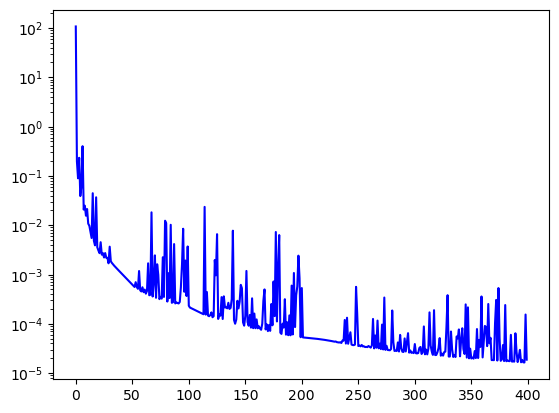

In [13]:
fig, ax = plt.subplots()
ax.plot(loss_hist, 'b')
ax.set_yscale('log')
plt.show()


In [14]:
# Testing trained model

# Number of test points
N_test_xy = 128**2
N_test_t = 64

# Absolute error

t_list = qmc.LatinHypercube(d=1).random(64)
error_u_list = 0.0 * t_list
for i in range(64):
    X_inner_test = qmc.LatinHypercube(d=2).random(128**2)
    x_test = X_inner_test[:, 0:1]
    y_test = X_inner_test[:, 1:2]
    t_test = 0.0 * x_test + t_list[i]
    z_test = z_val(x_test, y_test)
    sign_test = sign_x(x_test, y_test)
    h_test = h_val(x_test, y_test)
    Exact_test = exact_u(x_test, y_test, sign_test, t_test)
    X_inner_test = np.hstack((X_inner_test, z_test, t_test))
    X_inner_test_torch = torch.tensor(X_inner_test).double().to(device).requires_grad_(True)

    with torch.no_grad():
        p_pred_torch = model_p(X_inner_test_torch)
        p_pred = (T - t_test) * h_test * p_pred_torch.detach().cpu().numpy()
        u_pred = np.minimum(0.0 * p_pred + 1.0, np.maximum(0.0 * p_pred - 1.0, -(1.0/alpha) * p_pred))

    error = np.absolute(u_pred - Exact_test)

    error_u_list[i] = np.linalg.norm(error,2)/np.sqrt(128**2)

error_u_2 = np.mean(error_u_list)
print('Error u (absolute 2-norm): %e' % (error_u_2))


Error u (absolute 2-norm): 1.580895e-04


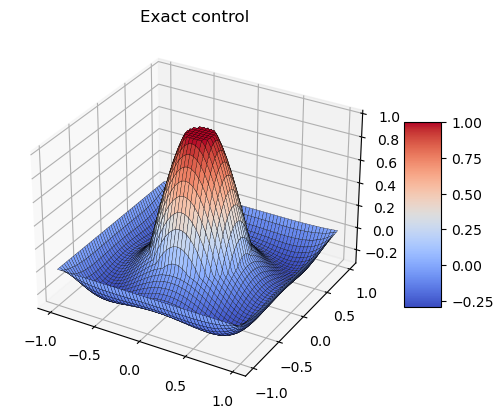

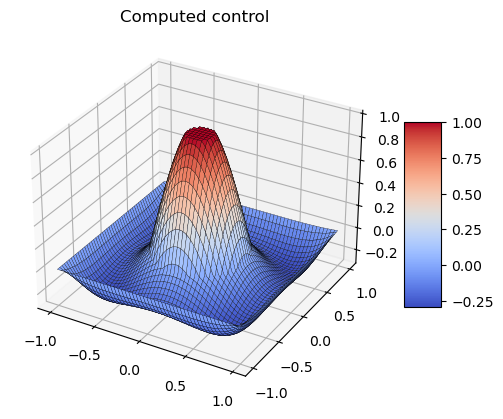

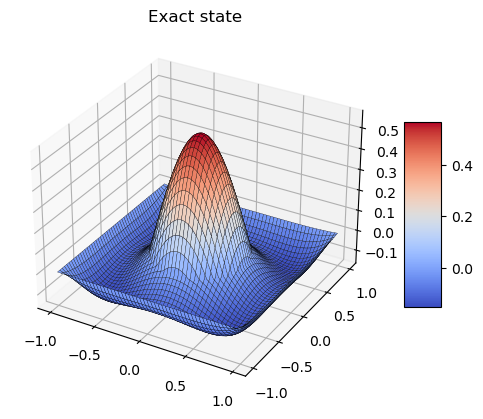

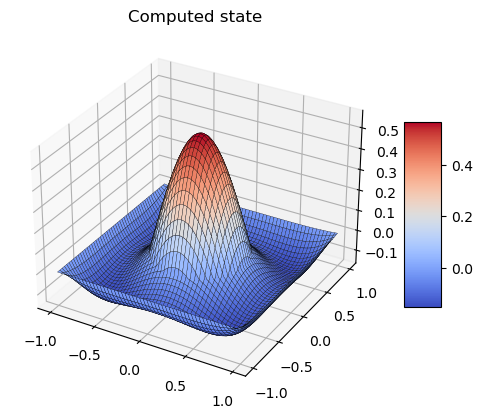

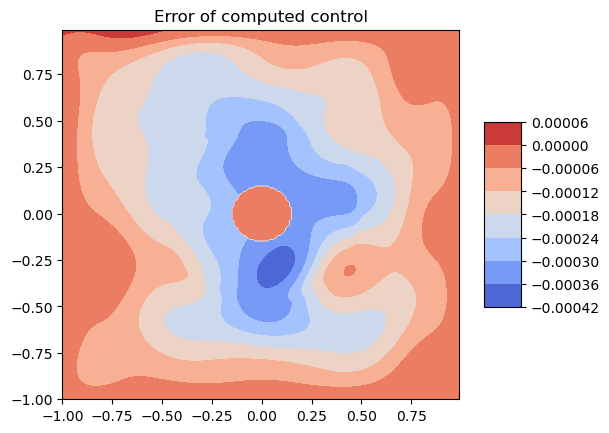

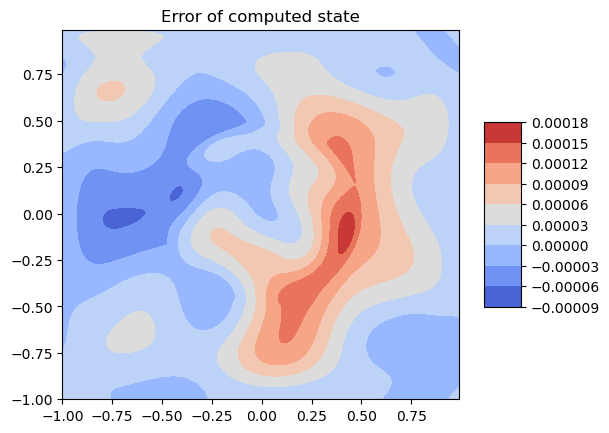

In [15]:
# Plot the solution

x_list = y_list = np.arange(-1, 1, 0.01)
x_mesh, y_mesh = np.meshgrid(x_list, y_list)
t_plot = 0.0 * x_mesh + 0.3 * T    # change this line to plot the solution at different t
z_plot = 0.0 * x_mesh + 1.0
sign_plot = 0.0 * x_mesh + 1.0
for i in range(len(z_plot)):
    for j in range(len(z_plot[i])):
        dist = np.sqrt(x_mesh[i, j]**2 + y_mesh[i, j]**2)
        if dist < r_0:
            z_plot[i, j] = 4.0 * (dist**2) 
            sign_plot[i, j] = -1.0

eu = exact_u(x_mesh, y_mesh, sign_plot, t_plot)
ev = exact_v(x_mesh, y_mesh, sign_plot, t_plot)
hhh = h_val(x_mesh, y_mesh)

x_mesh_r = x_mesh.reshape(40000)
y_mesh_r = y_mesh.reshape(40000)
z_plot_r = z_plot.reshape(40000)
hhhr = hhh.reshape(40000, 1)
t_plot_r = t_plot.reshape(40000)
temp = np.stack((x_mesh_r, y_mesh_r, z_plot_r, t_plot_r), axis=-1)
t_plot_r = t_plot.reshape(40000, 1)
temp_torch = torch.tensor(temp).double().to(device)
pp = model_p(temp_torch).detach().cpu().numpy()
pv = model_v(temp_torch).detach().cpu().numpy()
pp = (T - t_plot_r) * hhhr * pp
pv = t_plot_r * hhhr * pv
pu = np.minimum(0.0 * pp + 1.0, np.maximum(0.0 * pp - 1.0, -(1.0/alpha) * pp))
pu = pu.reshape(200, 200)
pv = pv.reshape(200, 200)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_eu = ax.plot_surface(x_mesh, y_mesh, eu, cmap=cm.coolwarm, linewidth=0.2)
surf_eu.set_edgecolors("black")
ax.title.set_text('Exact control')
fig.colorbar(surf_eu, shrink=0.5, aspect=5)
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_pu = ax.plot_surface(x_mesh, y_mesh, pu, cmap=cm.coolwarm, linewidth=0.2)
surf_pu.set_edgecolors("black")
ax.title.set_text('Computed control')
fig.colorbar(surf_pu, shrink=0.5, aspect=5)
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_ev = ax.plot_surface(x_mesh, y_mesh, ev, cmap=cm.coolwarm, linewidth=0.2)
surf_ev.set_edgecolors("black")
ax.title.set_text('Exact state')
fig.colorbar(surf_ev, shrink=0.5, aspect=5)
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_pv = ax.plot_surface(x_mesh, y_mesh, pv, cmap=cm.coolwarm, linewidth=0.2)
surf_pv.set_edgecolors("black")
ax.title.set_text('Computed state')
fig.colorbar(surf_pv, shrink=0.5, aspect=5)
plt.show()

fig, ax = plt.subplots()
surf_u_diff = ax.contourf(x_mesh, y_mesh, pu - eu, cmap=cm.coolwarm)
fig.colorbar(surf_u_diff, shrink=0.5, aspect=5)
ax.title.set_text('Error of computed control')
plt.show()

fig, ax = plt.subplots()
surf_v_diff = ax.contourf(x_mesh, y_mesh, pv - ev, cmap=cm.coolwarm)
fig.colorbar(surf_v_diff, shrink=0.5, aspect=5)
ax.title.set_text('Error of computed state')
plt.show()

In [16]:
# Save model, loss log and data set

model_filename = "results/ex5_alg2_trained_model.pt"
torch.save({"model_v_state_dict": model_v.state_dict(),
            "model_p_state_dict": model_p.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()}, model_filename)

csvfile = open("results/ex5_alg_2_loss_hist.csv", 'w')
writer = csv.writer(csvfile)
writer.writerow(loss_hist)
csvfile.close()

data_filename_train = "results/ex5_alg2_data_train.npz"
np.savez(data_filename_train, X_inner=X_inner.cpu().detach().numpy(), X_ij=X_ij.cpu().detach().numpy())

data_filename_test = "results/ex5_alg2_data_test.npz"
np.savez(data_filename_test, X_inner_test=X_inner_test)


In [17]:
# Load trained model

# model_v = PINN(3, 100, 1).to(device)
# model_p = PINN(3, 100, 1).to(device)
# optimizer = torch.optim.Adam(
#     list(model_v.parameters()) + list(model_p.parameters()),
#     lr=0.001)

# model_filename = "results/ex1_alg2_trained_model.pt"
# checkpoint = torch.load(model_filename)
# model_v.load_state_dict(checkpoint['model_v_state_dict'])
# model_p.load_state_dict(checkpoint['model_p_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
